In [1]:
import os
ROOT = "./checkpoints/resnet-cifar+CIFAR10"
ckpt_fns = os.listdir(ROOT)
ckpts = [os.path.join(ROOT, c) for c in ckpt_fns]
print(ckpts)

['./checkpoints/resnet-cifar+CIFAR10/epoch=0000-val_acc_seen=0.12.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0000-val_acc_seen=0.00.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0000-val_acc_seen=0.59.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0001-val_acc_seen=0.68.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0002-val_acc_seen=0.64.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0003-val_acc_seen=0.75.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0004-val_acc_seen=0.77.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0005-val_acc_seen=0.80.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0006-val_acc_seen=0.80.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0007-val_acc_seen=0.81.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0008-val_acc_seen=0.79.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0009-val_acc_seen=0.83.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0019-val_acc_seen=0.86.ckpt', './checkpoints/resnet-cifar+CIFAR10/epoch=0029-val_acc_seen=0.8

In [2]:
eps = [int(c[6:10]) for c in ckpt_fns]
print(list(zip(eps, ckpts)))

[(0, './checkpoints/resnet-cifar+CIFAR10/epoch=0000-val_acc_seen=0.12.ckpt'), (0, './checkpoints/resnet-cifar+CIFAR10/epoch=0000-val_acc_seen=0.00.ckpt'), (0, './checkpoints/resnet-cifar+CIFAR10/epoch=0000-val_acc_seen=0.59.ckpt'), (1, './checkpoints/resnet-cifar+CIFAR10/epoch=0001-val_acc_seen=0.68.ckpt'), (2, './checkpoints/resnet-cifar+CIFAR10/epoch=0002-val_acc_seen=0.64.ckpt'), (3, './checkpoints/resnet-cifar+CIFAR10/epoch=0003-val_acc_seen=0.75.ckpt'), (4, './checkpoints/resnet-cifar+CIFAR10/epoch=0004-val_acc_seen=0.77.ckpt'), (5, './checkpoints/resnet-cifar+CIFAR10/epoch=0005-val_acc_seen=0.80.ckpt'), (6, './checkpoints/resnet-cifar+CIFAR10/epoch=0006-val_acc_seen=0.80.ckpt'), (7, './checkpoints/resnet-cifar+CIFAR10/epoch=0007-val_acc_seen=0.81.ckpt'), (8, './checkpoints/resnet-cifar+CIFAR10/epoch=0008-val_acc_seen=0.79.ckpt'), (9, './checkpoints/resnet-cifar+CIFAR10/epoch=0009-val_acc_seen=0.83.ckpt'), (19, './checkpoints/resnet-cifar+CIFAR10/epoch=0019-val_acc_seen=0.86.ckpt'

In [3]:
import main as main_expr

import torch
from pytorch_lightning import LightningModule, Trainer
from torch import nn
from torch.nn import functional as F

import numpy as np

from nets import net_dict
from blurpower_expr_quantities import QuantityBase

from uq_models.param_inject import *
from func_dropout import *
from functorch import make_functional, make_functional_with_buffers, jvp, grad

class QComputeGrad(QuantityBase):
    
    def fnet_single_hvp(self, x, y_index = 0):

        # Torch 2.0 / CUDA 11.7
        # def foo(params):
        #     return torch.func.functional_call(self, params, (x,))[0, y_index]

        # Torch 1.13 / FuncTorch
        def foo(params):

            result = self.fnet(params, self.fbuffer, x)[0]

            resolved_y_index = y_index
            if resolved_y_index < 0:
                resolved_y_index = torch.argmax(result)

            return result[resolved_y_index]
        
        return foo

    def preprocess(self, net, head):

        # self.perturb_power = self.args.perturb_power 
        
        # InjectNet(net, noise_norm = self.perturb_power)
        # InjectNet(head, noise_norm = self.perturb_power)

        self.combined_net = nn.Sequential(net, head)
        self.combined_net.eval()
        self.y_index = 0

        # Calculate hessian bound
        # Torch 1.13 / FuncTorch
        funcresult = make_functional_with_buffers(self.combined_net)
        self.fnet, _, self.fbuffer = funcresult
        self.fparams = dict(self.combined_net.named_parameters())
        
        # Torch 2.0 / CUDA 11.7
        # self.fparams = dict(self.combined_net.named_parameters())

#         self.hessianResults = DropoutHessianRecorder()
        self.gradResults = DropoutHessianRecorder()
        self.gradResults_train = DropoutHessianRecorder()
        self.paramResults = DropoutHessianRecorder()

        self.device = torch.device('cuda')

        for batch_id in range(16):

            # Generate data
            # x = torch.randn(self.args.batch_size, 3, 224, 224, device = self.device)
            x = torch.randn(1, 3, 224, 224, device = self.device)

            # Torch 2.0 / CUDA 11.7
#             grad = torch.func.grad(self.fnet_single_hvp(x, 0))
#             grad_result = grad((self.fparams,))[0]
#             hvp_result = torch.func.jvp(grad, (self.fparams,), (params_randn_like(self.fparams),))[1]

            # Torch 1.13 / FuncTorch
            grad_result = grad(self.fnet_single_hvp(x, self.y_index))(to_unnamed(self.fparams))
            grad_result = unnamed_tuple_to_named(self.fparams, grad_result)

            self.gradResults.record(grad_result)
#             self.hessianResults.record(hvp_result)

        # Placeholder workaround to calculate paramater statstics
        self.paramResults.record(self.fparams)
        self.paramResults.record(self.fparams)

#         VisualizeHessianBound(self.paramResults, "Parameters")
#         VisualizeHessianBound(self.gradResults, "Gradient")
#         VisualizeHessianBound(self.hessianResults, "Hessian")

        return net, head

    def evaluate(self, net, head, batch):
        
        i, x, y = batch
        
        grad_result = grad(self.fnet_single_hvp(x, self.y_index))(to_unnamed(self.fparams))
        grad_result = unnamed_tuple_to_named(self.fparams, grad_result)

        self.gradResults_train.record(grad_result)
        
    def summary(self, is_ref, results):
        means = self.gradResults_train.mean()
        self.final_result = {}
        for i, k in enumerate(means):
#             self.final_result[k] = (means[k].norm() / math.sqrt(torch.numel(means[k]))).detach().cpu().item()
            self.final_result[k] = (torch.abs(means[k]).mean()).detach().cpu().item()

class QComputeParam(QuantityBase):
    
    def preprocess(self, net, head):
        self.combined_net = nn.Sequential(net, head)
        self.fparams = dict(self.combined_net.named_parameters())
        self.paramResults = DropoutHessianRecorder()
        self.paramResults.record(self.fparams)
        self.paramResults.record(self.fparams)
        return net, head
    
    def summary(self, is_ref, results):
        means = self.paramResults.mean()
        self.final_result = {}
        for i, k in enumerate(means):
#             self.final_result[k] = (means[k].norm() / math.sqrt(torch.numel(means[k]))).detach().cpu().item()
            self.final_result[k] = (means[k].norm() / math.sqrt(torch.numel(means[k]))).detach().cpu().item()

In [4]:
def filter_rename_ckpt(state_dict, prefix):
    filtered_dict = {}
    for k in state_dict:
        if k.startswith("%s." % prefix):
            filtered_dict[k.replace("%s." % prefix, "", 1)] = state_dict[k]
    return filtered_dict

In [5]:
reference_data_count = 1024
test_set_max = 1024
net_name = 'resnet-cifar'

##############################
# Prepare dataloader
##############################

main_datamodule, input_dim = main_expr.get_data_module(
    "cifar10",
    128,
    data_augmentation = True,
    num_workers=0,
    do_partial_train = False,
    do_contamination = False,
    test_set_max = test_set_max,
    is_binary = False,
    noise_std = 0.0,
    blur_sigma = 0.0)

main_datamodule.setup()
# Q = QComputeParam(None)
Q = QComputeGrad(None)

indices = None
if indices is None:
    indices = np.random.choice(len(main_datamodule.test_dataset), size = (reference_data_count,))

calibration_data = torch.utils.data.Subset(
    main_datamodule.test_dataset,
    np.random.choice(len(main_datamodule.test_dataset), size = (reference_data_count,))
)

calibration_dl = torch.utils.data.DataLoader(
    calibration_data,
    batch_size = 128,
    shuffle = False,
    num_workers = 0
)

##############################
# Get Net
##############################

output_dim = main_datamodule.n_classes

results = []

for i in range(len(ckpts)):
    
    print("Ep #%04d" % eps[i])
    
    net_factory = net_dict[net_name]()
    net, head = net_factory.getNets(
        input_dim, 
        [output_dim],
        hidden_dim = 2048,
        dropout_rate = 0.85
    )

    path = ckpts[i]
    loaded = torch.load(path)["state_dict"]
    net.load_state_dict(filter_rename_ckpt(loaded, "net"))
    head.load_state_dict(filter_rename_ckpt(loaded, "head"))

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    net = net.to(device)
    head = head.to(device)

    net, head = Q.preprocess(net, head)

    ##############################
    # Feed the beast
    ##############################

    q_evals = []

    for batch in calibration_dl:
        batch = [b.to(device) for b in batch]
#         print(batch)
        q_eval = Q.evaluate(net, head, batch)
        q_evals.append(q_eval)

    Q.summary(False, q_evals)
    
    results.append(Q.final_result)

Loading raw datasets...
Files already downloaded and verified
Files already downloaded and verified
Capping test set...
Wrapping datasets...
Ep #0000
conv1_type:cifar
no_maxpool:True
Ep #0000
conv1_type:cifar
no_maxpool:True
Ep #0000
conv1_type:cifar
no_maxpool:True
Ep #0001
conv1_type:cifar
no_maxpool:True
Ep #0002
conv1_type:cifar
no_maxpool:True
Ep #0003
conv1_type:cifar
no_maxpool:True
Ep #0004
conv1_type:cifar
no_maxpool:True
Ep #0005
conv1_type:cifar
no_maxpool:True
Ep #0006
conv1_type:cifar
no_maxpool:True
Ep #0007
conv1_type:cifar
no_maxpool:True
Ep #0008
conv1_type:cifar
no_maxpool:True
Ep #0009
conv1_type:cifar
no_maxpool:True
Ep #0019
conv1_type:cifar
no_maxpool:True
Ep #0029
conv1_type:cifar
no_maxpool:True
Ep #0039
conv1_type:cifar
no_maxpool:True
Ep #0049
conv1_type:cifar
no_maxpool:True
Ep #0059
conv1_type:cifar
no_maxpool:True
Ep #0069
conv1_type:cifar
no_maxpool:True
Ep #0079
conv1_type:cifar
no_maxpool:True
Ep #0089
conv1_type:cifar
no_maxpool:True
Ep #0099
conv1_type

In [6]:
import csv

# outpath = "params.csv"
outpath = "grads_train.csv"

# Combine all results
all_results = {k: [r[k] for r in results] for k in results[0].keys()}

with open(outpath, 'w') as csvfile:
    wtr = csv.writer(csvfile, delimiter = ',')
    wtr.writerow(["Layer name", *["%d" % e for e in eps]])
    for k in all_results.keys():
        wtr.writerow([k, *all_results[k]])

Text(0.5, 1.0, 'Layer-wise gradient mean abs. on training set ResNet-18 CIFAR-10 AdamW over 400 epochs')

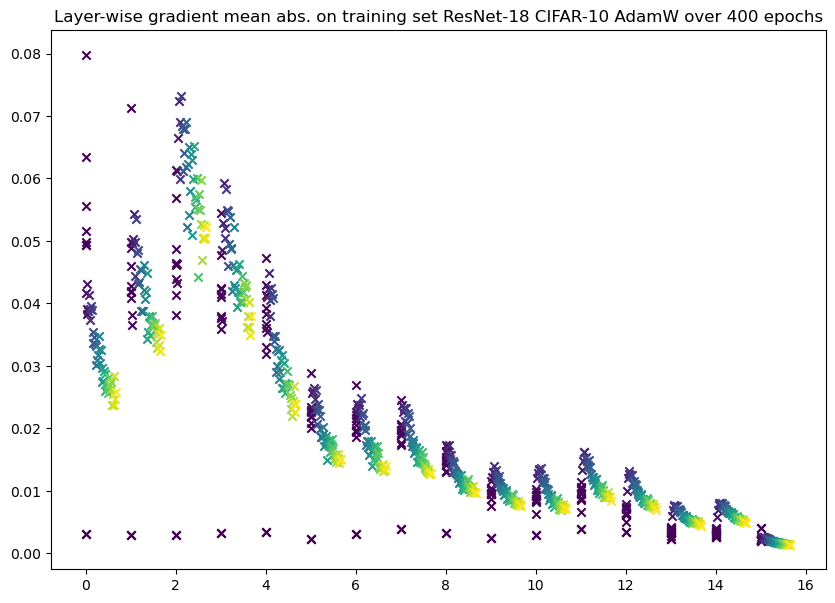

In [20]:
from matplotlib import pyplot as plt
import matplotlib

all_convs = {k: all_results[k] for k in list(all_results.keys())[1:] if 'conv' in k}
fig, ax = plt.subplots(figsize = (10, 7))

cmap = matplotlib.colormaps['viridis']

for i, ep in enumerate(eps):
    ax.scatter(
        [x + (ep / 600.0) for x in list(range(len(all_convs.keys())))],
        [all_convs[k][i] for k in all_convs.keys()],
        color = cmap(ep / 400.0),
        marker = 'x',
        alpha = 1.0
    )
#     break

# print(all_convs)
ax.set_title("Layer-wise gradient mean abs. on training set ResNet-18 CIFAR-10 AdamW over 400 epochs")